In [30]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import numpy as np
import seaborn as sns

import missingno as msno
import datetime

## Download Streamflow data
San Lorenzo River, Santa Cruz County, California
USGS streamflow data is in *local* time... so loses an hour or missing an hour at each time zone. Change data to be in PST so it matches clock time in the winter when the most "action" is. 

In [3]:
# import Santa Cruz streamflow data for San Lorenzo River
site = '11161000'
code = '00060'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2023-09-30T00:00:00.000-07:00'

usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
api_response = requests.get(usgs_water_api)

water_data = api_response.json()
data_only = water_data['value']['timeSeries'][0]['values'][0]['value']

streamflow_SC_raw = pd.DataFrame(data_only).sort_values('dateTime')
streamflow_SC_raw.head()

,value,qualifiers,dateTime
0,4.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00
1,4.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00
2,3.90,"[A, [91]]",1987-10-01T00:45:00.000-07:00
3,3.70,"[A, [91]]",1987-10-01T01:00:00.000-07:00
4,3.20,"[A, [91]]",1987-10-01T01:15:00.000-07:00


In [4]:
#import streamflow data for San Lorenzo River at Big Trees
site = '11160500'
code = '00060'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2023-09-30T00:00:00.000-07:00'

usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
api_response = requests.get(usgs_water_api)

water_data = api_response.json()
data_only = water_data['value']['timeSeries'][0]['values'][0]['value']

streamflow_BT_raw = pd.DataFrame(data_only).sort_values('dateTime')
streamflow_BT_raw.head()


,value,qualifiers,dateTime
0,9.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00
1,9.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00
2,9.40,"[A, [91]]",1987-10-01T00:45:00.000-07:00
3,9.40,"[A, [91]]",1987-10-01T01:00:00.000-07:00
4,9.40,"[A, [91]]",1987-10-01T01:15:00.000-07:00


In [5]:
# combine streamflow data into one df

def process_streamflow(streamflow_data):
    #create datetime index
    streamflow_data.index = pd.to_datetime([x[0:-6] for x in streamflow_data['dateTime']]) 

    # convert data to PST (-08:00) 
    streamflow_data['tz'] = [x[-6::] for x in streamflow_data['dateTime']]
    streamflow_data.loc[streamflow_data.tz == '-07:00', :].index = streamflow_data.loc[streamflow_data.tz == '-07:00', :].index - pd.Timedelta(1, 'hour')

    #rename cols
    col_mapper = {'value': 'q_cfs', 'qualifiers': 'code'}
    streamflow_data.rename(col_mapper, axis=1, inplace=True) # rename cols

    #cfs to numeric 
    streamflow_data['q_cfs'] = streamflow_data['q_cfs'].apply(pd.to_numeric)

    # resample to 15 min to account for timechange dupes
    streamflow_data_resample = streamflow_data.resample('15min').agg({'q_cfs': 'mean',
                                                                     'code': 'first', 
                                                                     'dateTime': 'first', 
                                                                     'tz': 'first'})
    return streamflow_data_resample


streamflow_BT = process_streamflow(streamflow_BT_raw)
streamflow_SC = process_streamflow(streamflow_SC_raw)


streamflow = pd.merge(streamflow_BT, streamflow_SC, how='outer', left_index=True, right_index=True, suffixes=['_BT', '_SC'])

streamflow.head()

,q_cfs_BT,code_BT,dateTime_BT,tz_BT,q_cfs_SC,code_SC,dateTime_SC,tz_SC
1987-10-01 00:15:00,9.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00
1987-10-01 00:30:00,9.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00
1987-10-01 00:45:00,9.4,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00,3.9,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00
1987-10-01 01:00:00,9.4,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00,3.7,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00
1987-10-01 01:15:00,9.4,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00,3.2,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00


## download precipitation data from Ben Lomond Station near Felton, CA within the San Lorenzo watershed. 
Data is event-based data, with timestamp saved for each tip of the rain tipping bucket. Code below recalculated to incremental data resampled to every 15 minutes. 

In [6]:
#download Ben Lomond precip data
cdec_bl_api = 'https://cdec.water.ca.gov/dynamicapp/req/JSONDataServlet?Stations=BLN&SensorNums=16&dur_code=E&Start=1997-12-10&End=2024-06-19'

response = requests.get(cdec_bl_api)
rain_data = response.json()


In [7]:
## clean event-based rain data (tip events to 15 minute data)
event_rain = pd.DataFrame(rain_data)
event_rain['dt'] = pd.to_datetime(event_rain['date'])
event_rain['inc'] = event_rain['value'].diff()

event_rain.sort_values('inc')
event_rain_cleaned = event_rain.loc[event_rain['dt'] > pd.to_datetime('2008-10-01'), :]
event_rain_cleaned.loc[event_rain_cleaned.inc < 0, 'inc'] = 0 #negative increments are when tip resets to zero
event_rain_cleaned.loc[event_rain_cleaned.inc >10, 'inc'] = 0 # greater than 10 are when cumulative precip jumps back up to cumulative after data drop

(14153.0, 19935.0)

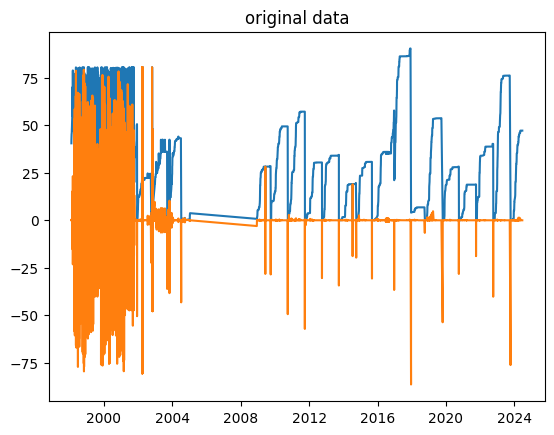

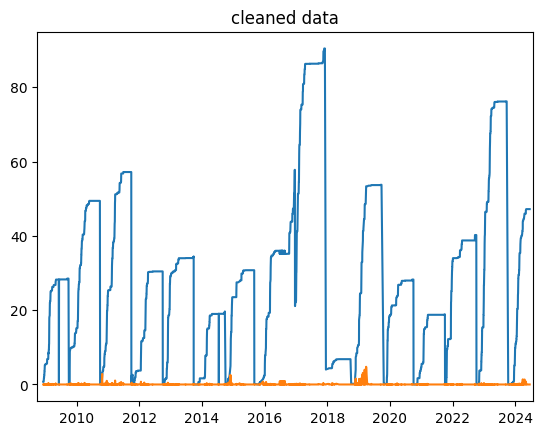

In [8]:
##use this plot code to explore data and iterate on cleaning above. I rerun multiple times to look at various parts of data
f, ax = plt.subplots(1, 1)
ax.plot(event_rain.dt, event_rain['value'])
ax.plot(event_rain.dt, event_rain['inc'])
ax.set_title('original data')

f, ax2 = plt.subplots(1, 1)
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned['value'])
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned.inc)
ax2.set_title('cleaned data')
ax2.set_xlim(pd.to_datetime('2008-10-01'), pd.to_datetime('2024-07-31'))

# ax2.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2019-06-01'))
# ax2.ylim(-1, 5)

In [9]:
event_rain_cleaned.head()

,stationId,durCode,SENSOR_NUM,sensorType,date,obsDate,value,dataFlag,units,dt,inc
16292,BLN,E,16,RAINTIP,2008-12-10 3:34,2008-12-10 3:34,0.71,,INCHES,2008-12-10 03:34:00,0.0
16293,BLN,E,16,RAINTIP,2008-12-10 15:34,2008-12-10 15:34,0.71,,INCHES,2008-12-10 15:34:00,0.0
16294,BLN,E,16,RAINTIP,2008-12-11 3:34,2008-12-11 3:34,0.71,,INCHES,2008-12-11 03:34:00,0.0
16295,BLN,E,16,RAINTIP,2008-12-11 15:34,2008-12-11 15:34,0.71,,INCHES,2008-12-11 15:34:00,0.0
16296,BLN,E,16,RAINTIP,2008-12-12 3:34,2008-12-12 3:34,0.71,,INCHES,2008-12-12 03:34:00,0.0


In [10]:
# resample event data to 15min; check min and max are reasonable and consistent with plots above 
event_rain_cleaned.index = event_rain_cleaned.dt
rain_15min = event_rain_cleaned[['inc']].resample('15min').sum()
rain_15min.rename({'inc': 'precip_in'}, axis=1, inplace=True)
rain_15min.describe()

,precip_in
count,544255.000000
mean,0.001217
std,0.018257
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4.760000


## Merge; Check for missing values
Data prior to water year 2008 is very messy, discard. 
Missing precip is filled with zero 
Missing streamflow is linearly interpolated. 

In [55]:
# combine all data into one df 

hydro_data = pd.merge(rain_15min, streamflow, how='outer', left_index=True, right_index=True)
hydro_data.head()

,precip_in,q_cfs_BT,code_BT,dateTime_BT,tz_BT,q_cfs_SC,code_SC,dateTime_SC,tz_SC
1987-10-01 00:15:00,NaN,9.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00
1987-10-01 00:30:00,NaN,9.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00
1987-10-01 00:45:00,NaN,9.4,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00,3.9,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00
1987-10-01 01:00:00,NaN,9.4,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00,3.7,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00
1987-10-01 01:15:00,NaN,9.4,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00,3.2,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00


In [56]:
# check for missing
hydro_data.isna().sum()

precip_in      743149
q_cfs_BT        35083
code_BT         35083
dateTime_BT     35083
tz_BT           35083
q_cfs_SC        62655
code_SC         62655
dateTime_SC     62655
tz_SC           62655
dtype: int64

<Axes: >

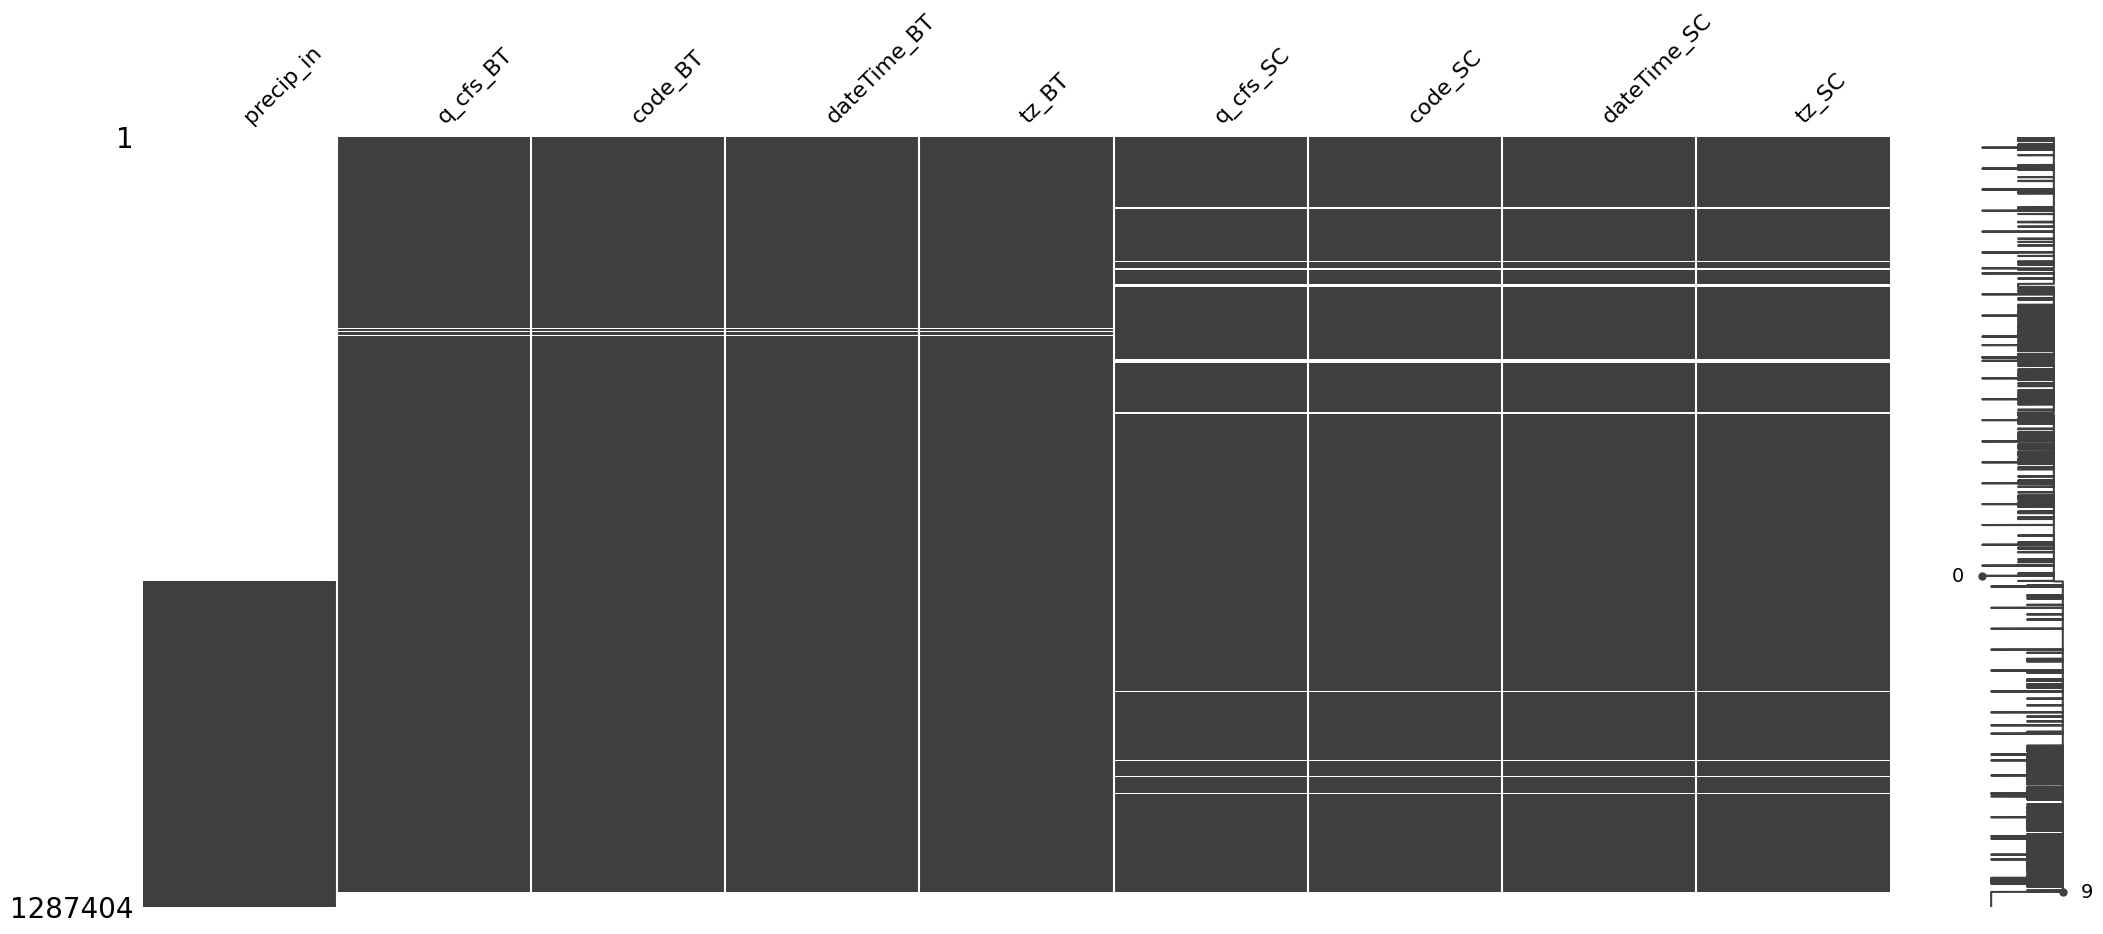

In [57]:
msno.matrix(hydro_data)

precip_in       6734
q_cfs_BT       26458
code_BT        26458
dateTime_BT    26458
tz_BT          26458
q_cfs_SC       31967
code_SC        31967
dateTime_SC    31967
tz_SC          31967
dtype: int64

<Axes: >

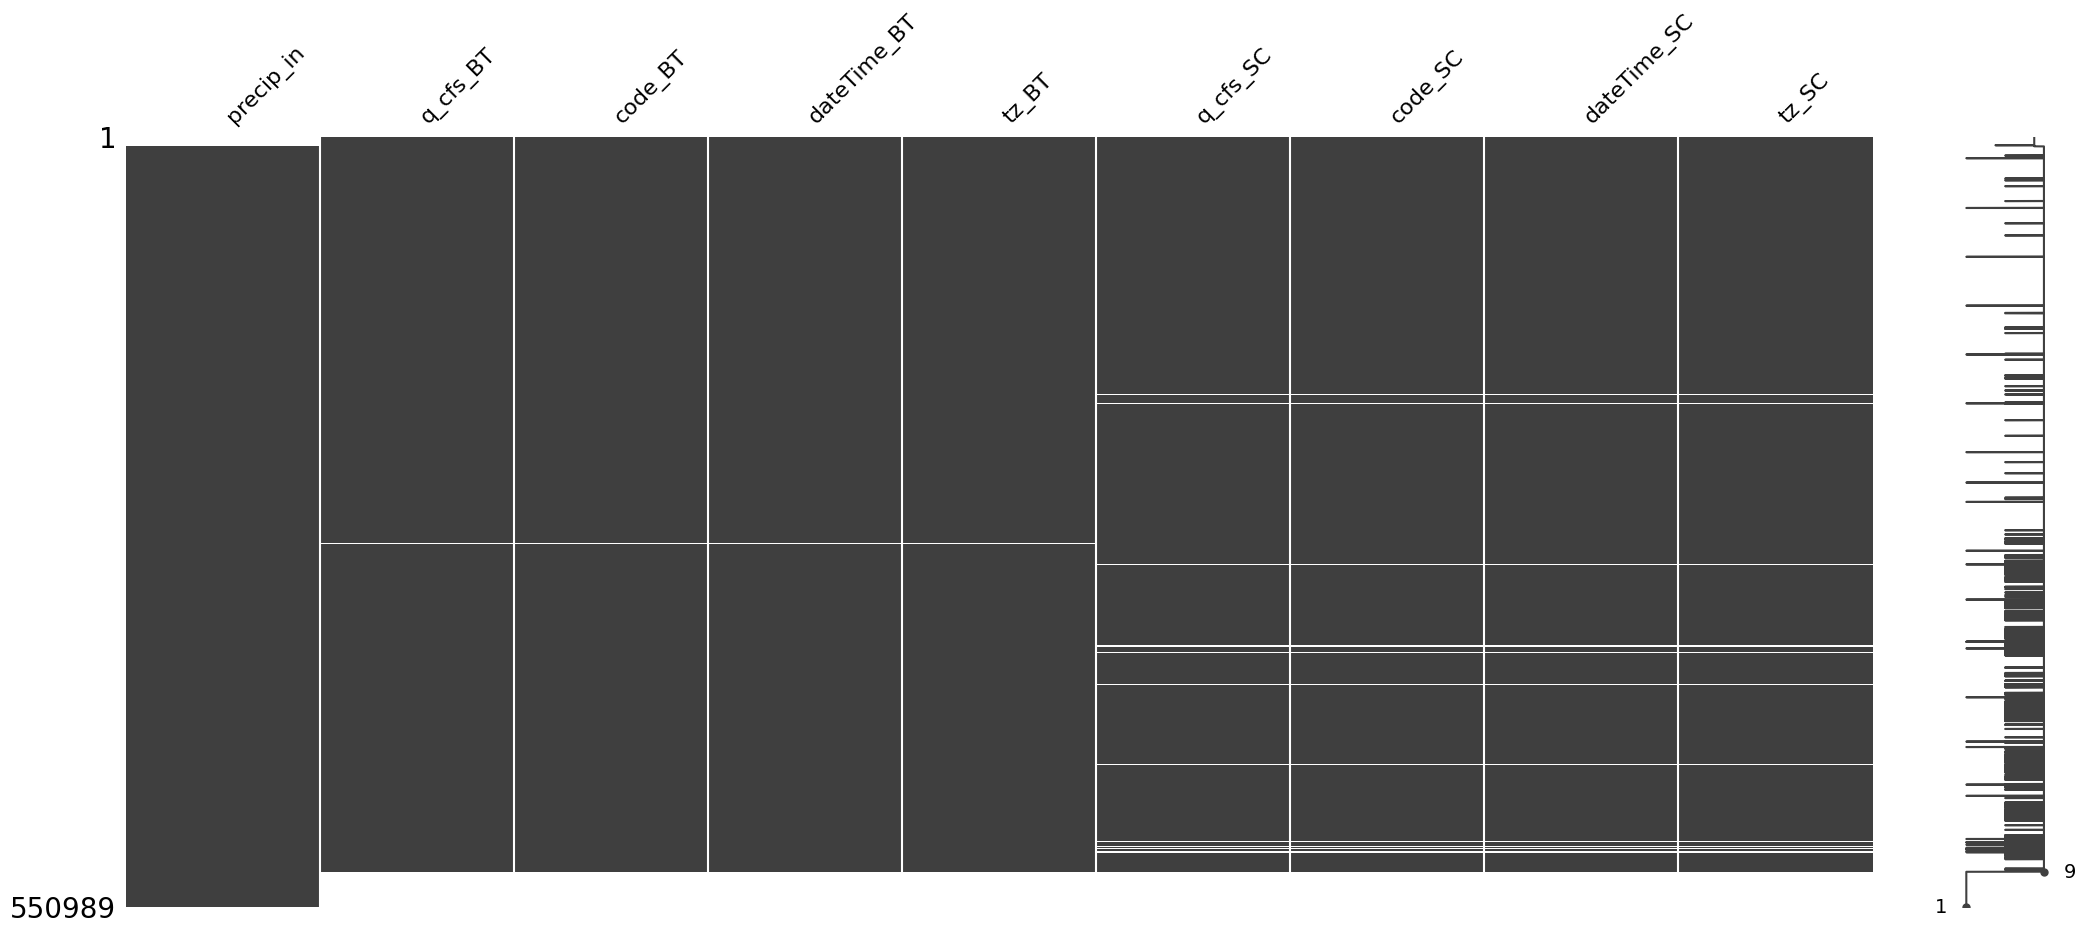

In [58]:
## keep only wy 2008 on; check for missing in that time period (much less)
hydro_data = hydro_data.loc[(hydro_data.index >= pd.to_datetime('2008-10-01'))]
display(hydro_data.isna().sum())
msno.matrix(hydro_data)

In [59]:
### fill precip with zero, it's incremental rainfall, so zero is appropriate
hydro_data.precip_in = hydro_data.precip_in.fillna(0)
display(hydro_data.isna().sum())



precip_in          0
q_cfs_BT       26458
code_BT        26458
dateTime_BT    26458
tz_BT          26458
q_cfs_SC       31967
code_SC        31967
dateTime_SC    31967
tz_SC          31967
dtype: int64

precip_in      float64
q_cfs_BT       float64
code_BT         object
dateTime_BT     object
tz_BT           object
q_cfs_SC       float64
code_SC         object
dateTime_SC     object
tz_SC           object
dtype: object

<Axes: >

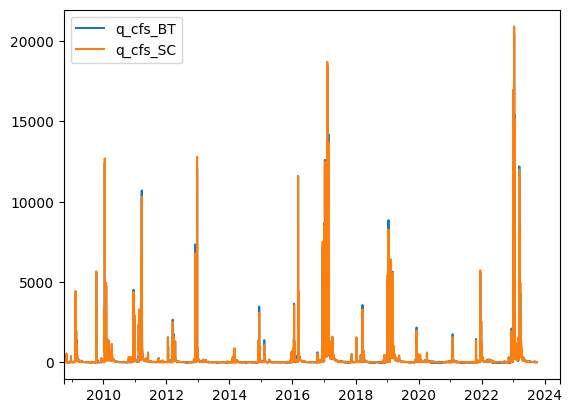

In [60]:
## code and datetime not important for modeling, so look at discharge
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].apply(pd.to_numeric)
display(hydro_data.dtypes)
hydro_data.plot(y=['q_cfs_BT', 'q_cfs_SC'])
# plt.yscale('log')

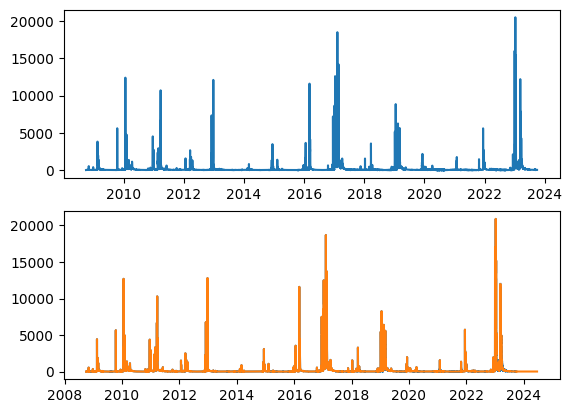

In [61]:
hydro_data[['q_cfs_BT_int', 'q_cfs_SC_int']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].interpolate()
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].fillna(-999)
f, ax = plt.subplots(2, 1)
ax[0].plot(hydro_data[['q_cfs_BT']])
# ax[0].plot(hydro_data.q_cfs_BT.isna() * 10000 - 5000, linestyle='', marker='.')
ax[1].plot(hydro_data[['q_cfs_SC', 'q_cfs_SC_int']])
# ax[0].set_yscale('log')
# ax[0].set_xlim(pd.to_datetime('2018-04-01'), pd.to_datetime('2018-05-01'))

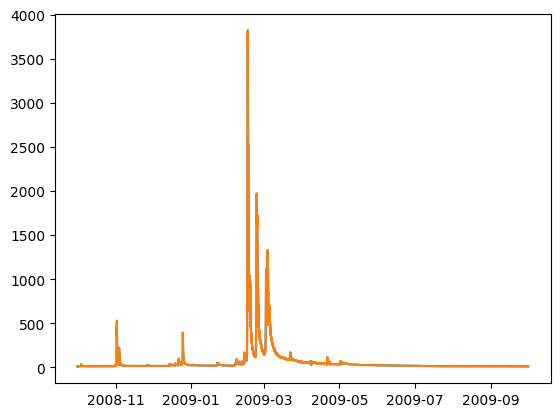

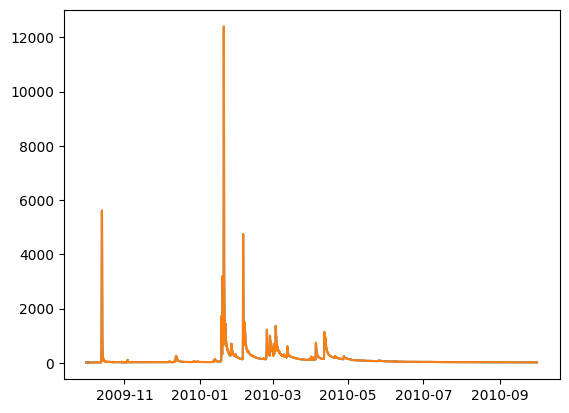

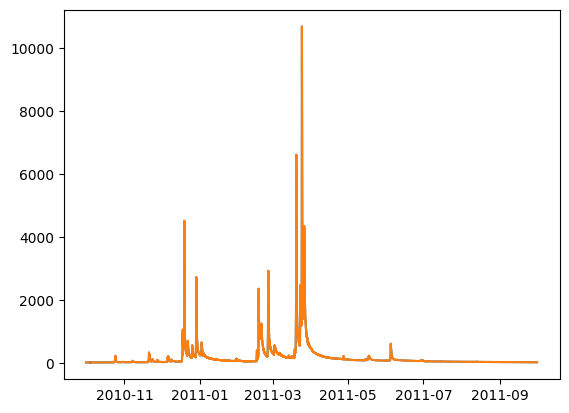

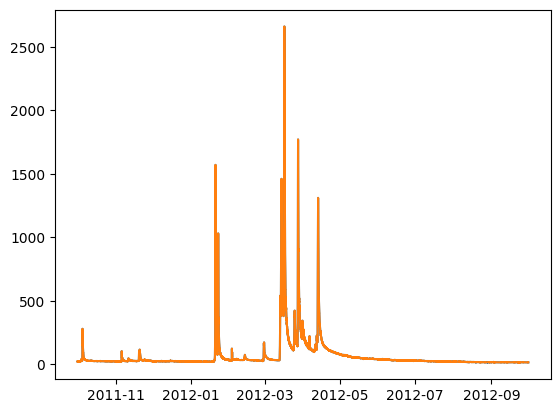

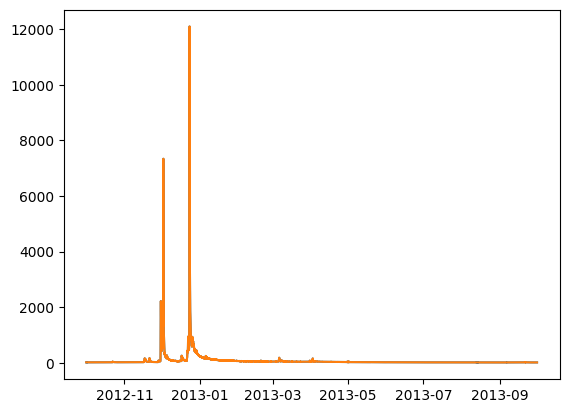

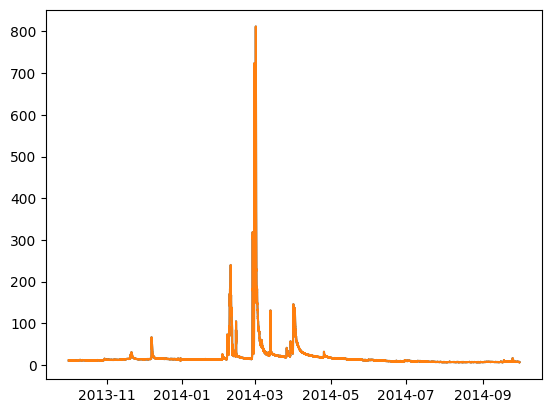

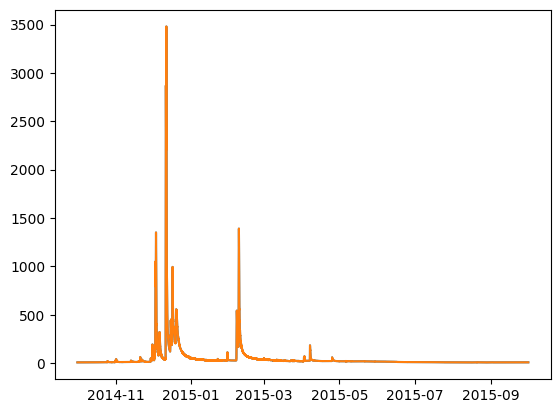

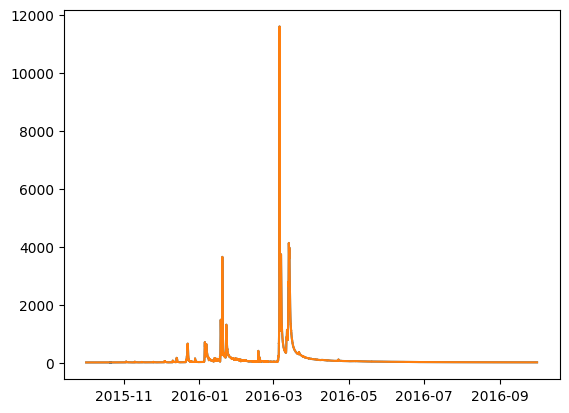

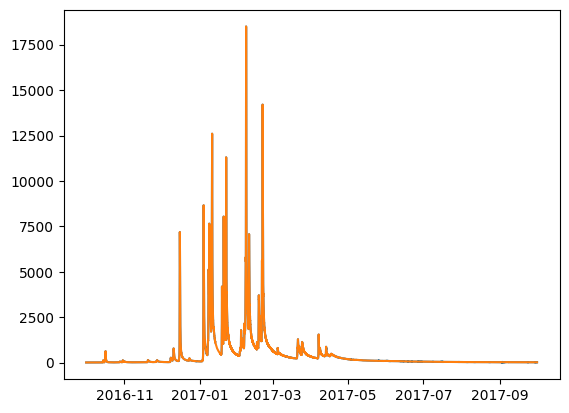

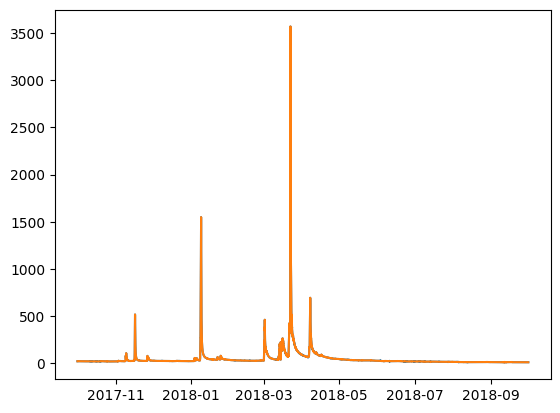

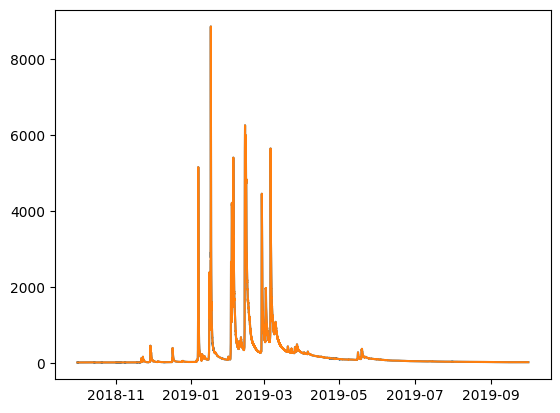

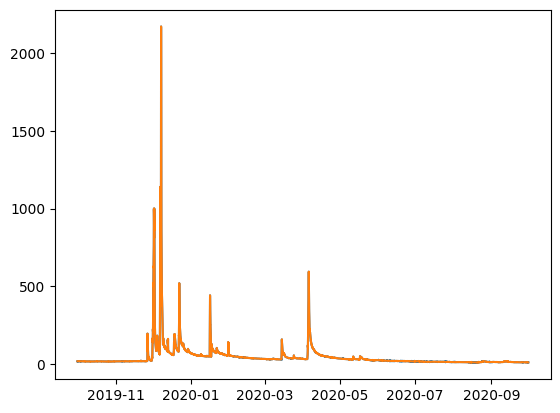

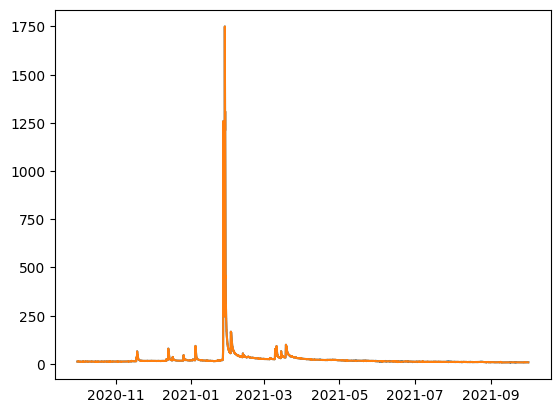

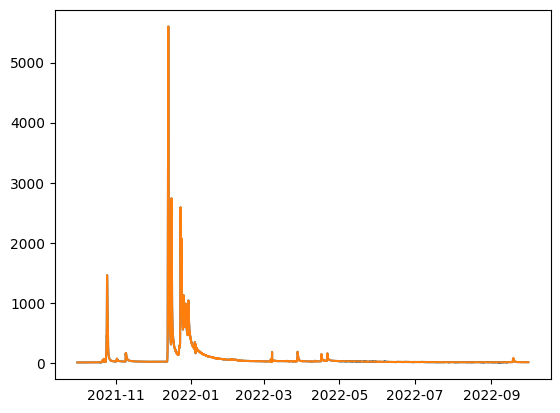

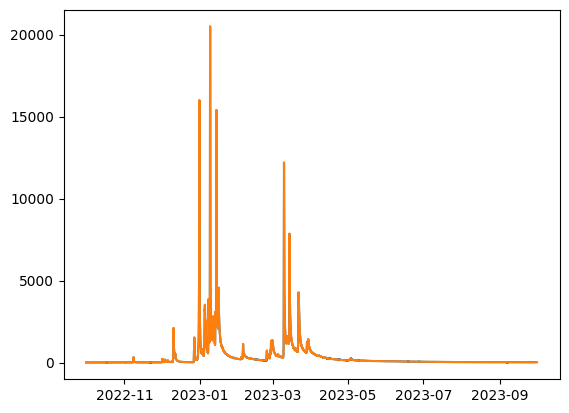

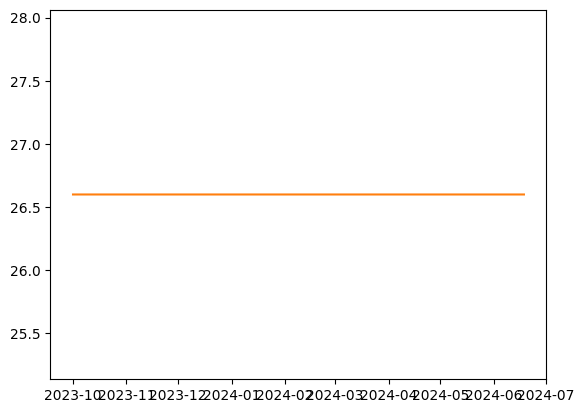

In [62]:
### plot each water year to visually check for interpolation problems

hydro_data['cy'] = hydro_data.index.year
hydro_data['month'] = hydro_data.index.month

hydro_data['wy'] = hydro_data.cy
hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'wy'] = hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'cy'] + 1

for wy in hydro_data['wy'].unique():
    f, ax = plt.subplots(1, 1)
    data_wy = hydro_data.loc[hydro_data['wy'] == wy, :]
    ax.plot(data_wy.index, data_wy[['q_cfs_BT', 'q_cfs_BT_int']])

In [63]:
#how many consecutive missing q values?
a = hydro_data[['q_cfs_BT', 'q_cfs_SC']].isna()
df1 = a.cumsum()-a.cumsum().where(~a).ffill().fillna(0).astype(int)
df1.max()/ 4 #hours

q_cfs_BT    6299.0
q_cfs_SC    6299.0
dtype: float64

In [64]:
hydro_data.isna().sum()
hydro_data_clean = hydro_data.drop(['q_cfs_BT', 'code_BT', 'dateTime_BT', 'q_cfs_SC', 'code_SC', 'dateTime_SC', 'tz_BT', 'tz_SC'], axis=1)

hydro_data_clean

,precip_in,q_cfs_BT_int,q_cfs_SC_int,cy,month,wy
2008-10-01 00:00:00,0.0,10.8,1.43,2008,10,2009
2008-10-01 00:15:00,0.0,10.8,1.26,2008,10,2009
2008-10-01 00:30:00,0.0,10.8,1.26,2008,10,2009
2008-10-01 00:45:00,0.0,10.8,1.26,2008,10,2009
2008-10-01 01:00:00,0.0,10.8,1.26,2008,10,2009
...,...,...,...,...,...,...
2024-06-18 10:00:00,0.0,26.6,16.80,2024,6,2024
2024-06-18 10:15:00,0.0,26.6,16.80,2024,6,2024
2024-06-18 10:30:00,0.0,26.6,16.80,2024,6,2024
2024-06-18 10:45:00,0.0,26.6,16.80,2024,6,2024


## Check for outliers
Weird binning makes date features look uneven, but they aren't. Verified below. 

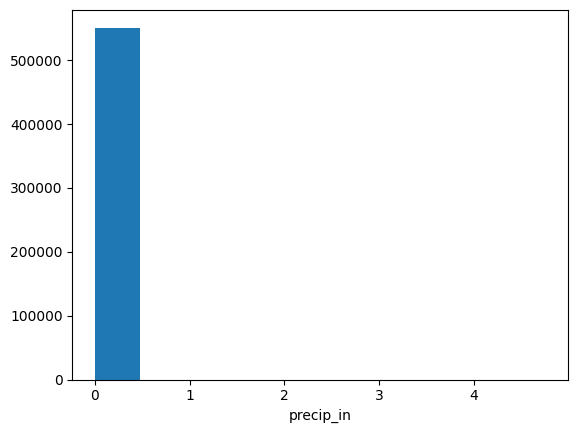

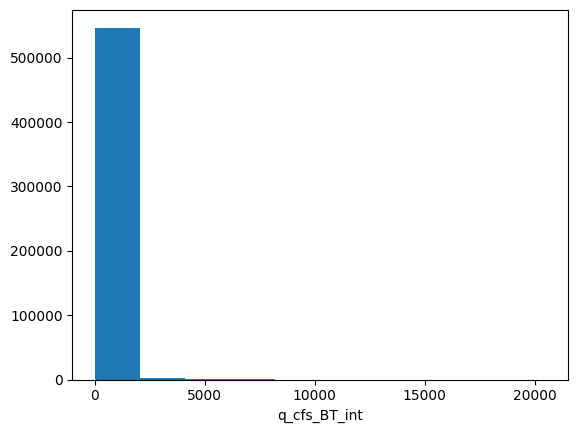

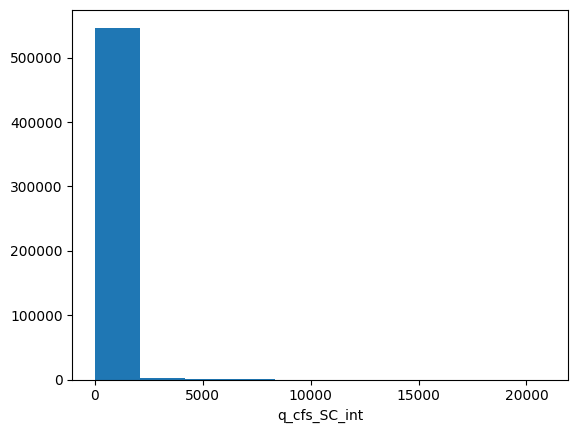

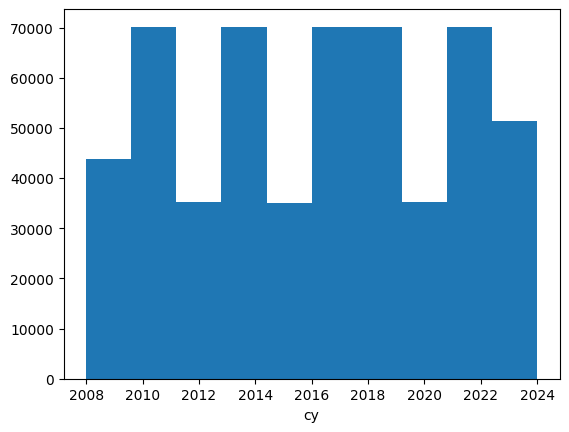

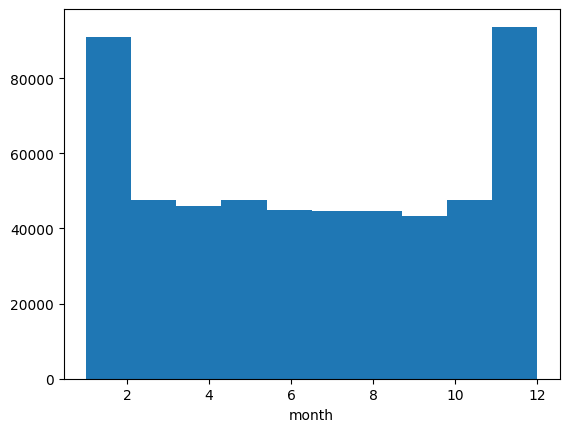

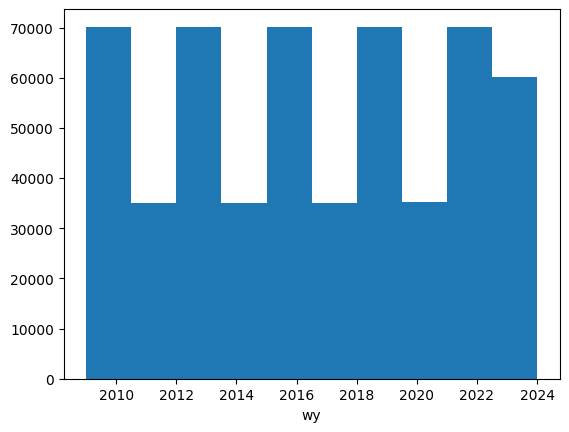

In [65]:
##outliers

for n in hydro_data_clean.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(hydro_data_clean[n])
    ax.set_xlabel(n)

# hydro_data_clean.head(20)

In [66]:
print('timestamp duplicates: ', hydro_data_clean.index.duplicated().sum())
display(hydro_data_clean.wy.value_counts())
display(hydro_data_clean.month.value_counts())

## no timestamp duplicates. Weird spikey histograms are binning issues. 

timestamp duplicates:  0


wy
2012    35136
2016    35136
2020    35136
2009    35040
2010    35040
2011    35040
2013    35040
2014    35040
2015    35040
2017    35040
2018    35040
2019    35040
2021    35040
2022    35040
2023    35040
2024    25101
Name: count, dtype: int64

month
10    47616
12    47616
1     47616
3     47616
5     47616
11    46080
4     46080
6     44877
7     44640
8     44640
2     43392
9     43200
Name: count, dtype: int64

## Add relevant wildfires and estimate percent of watershed burned. 

In [67]:
## wildfires
wildfire_percent = {2017: 341.136 / 88320.0, # https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/about
                   2020: 0.2} # https://www.cityofsantacruz.com/government/city-departments/water/water-quality/czu-fire-water-quality

# wildfire_percent = pd.DataFrame(wildfire_percent, index=[0, 1])
wildfire_percent[2017]

0.0038625000000000005

## Download drought index data 
from https://www.drought.gov/historical-information?dataset=0&selectedDateUSDM=20240618
for Santa Cruz County

In [68]:
#drought data, SC county

drought_data = pd.read_csv('USDM-06087.csv', parse_dates=['ValidStart', 'ValidEnd'])
drought_data.rename({'ValidStart': 'week_start'}, axis=1, inplace=True)
drought_data.index = drought_data.week_start
drought_data = drought_data[['D0', 'D1', 'D2', 'D3', 'D4']].copy()
drought_data = drought_data.sort_index()
drought_data#.loc[pd.to_datetime('2008-10-01'), :]

,D0,D1,D2,D3,D4
week_start,,,,,
2000-01-04,0.0,0.0,0.0,0.0,0.0
2000-01-11,0.0,0.0,0.0,0.0,0.0
2000-01-18,0.0,0.0,0.0,0.0,0.0
2000-01-25,0.0,0.0,0.0,0.0,0.0
2000-02-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-05-21,0.0,0.0,0.0,0.0,0.0
2024-05-28,0.0,0.0,0.0,0.0,0.0
2024-06-04,0.0,0.0,0.0,0.0,0.0


In [69]:
#merge drought and wildfire data
drought_data_15min = drought_data.resample('15min').ffill()
data = pd.merge(hydro_data_clean, drought_data_15min, left_index=True, right_index=True, how='left')
data = pd.merge(hydro_data_clean, drought_data_15min, left_index=True, right_index=True, how='left')

for k in wildfire_percent.keys():
    data.loc[data['wy'] == k, 'wildfire_percent'] = wildfire_percent[k]

data[['wildfire_percent']] = data[['wildfire_percent']].fillna(0)

In [70]:
#final nan/duplicate checks

display(data.isna().sum())
print('duplicates: ', data.index.duplicated().sum())

precip_in            0
q_cfs_BT_int         0
q_cfs_SC_int         0
cy                   0
month                0
wy                   0
D0                  44
D1                  44
D2                  44
D3                  44
D4                  44
wildfire_percent     0
dtype: int64

duplicates:  0


## Check variable correlations
Will likely use LSTM so checking lagged correlation as well

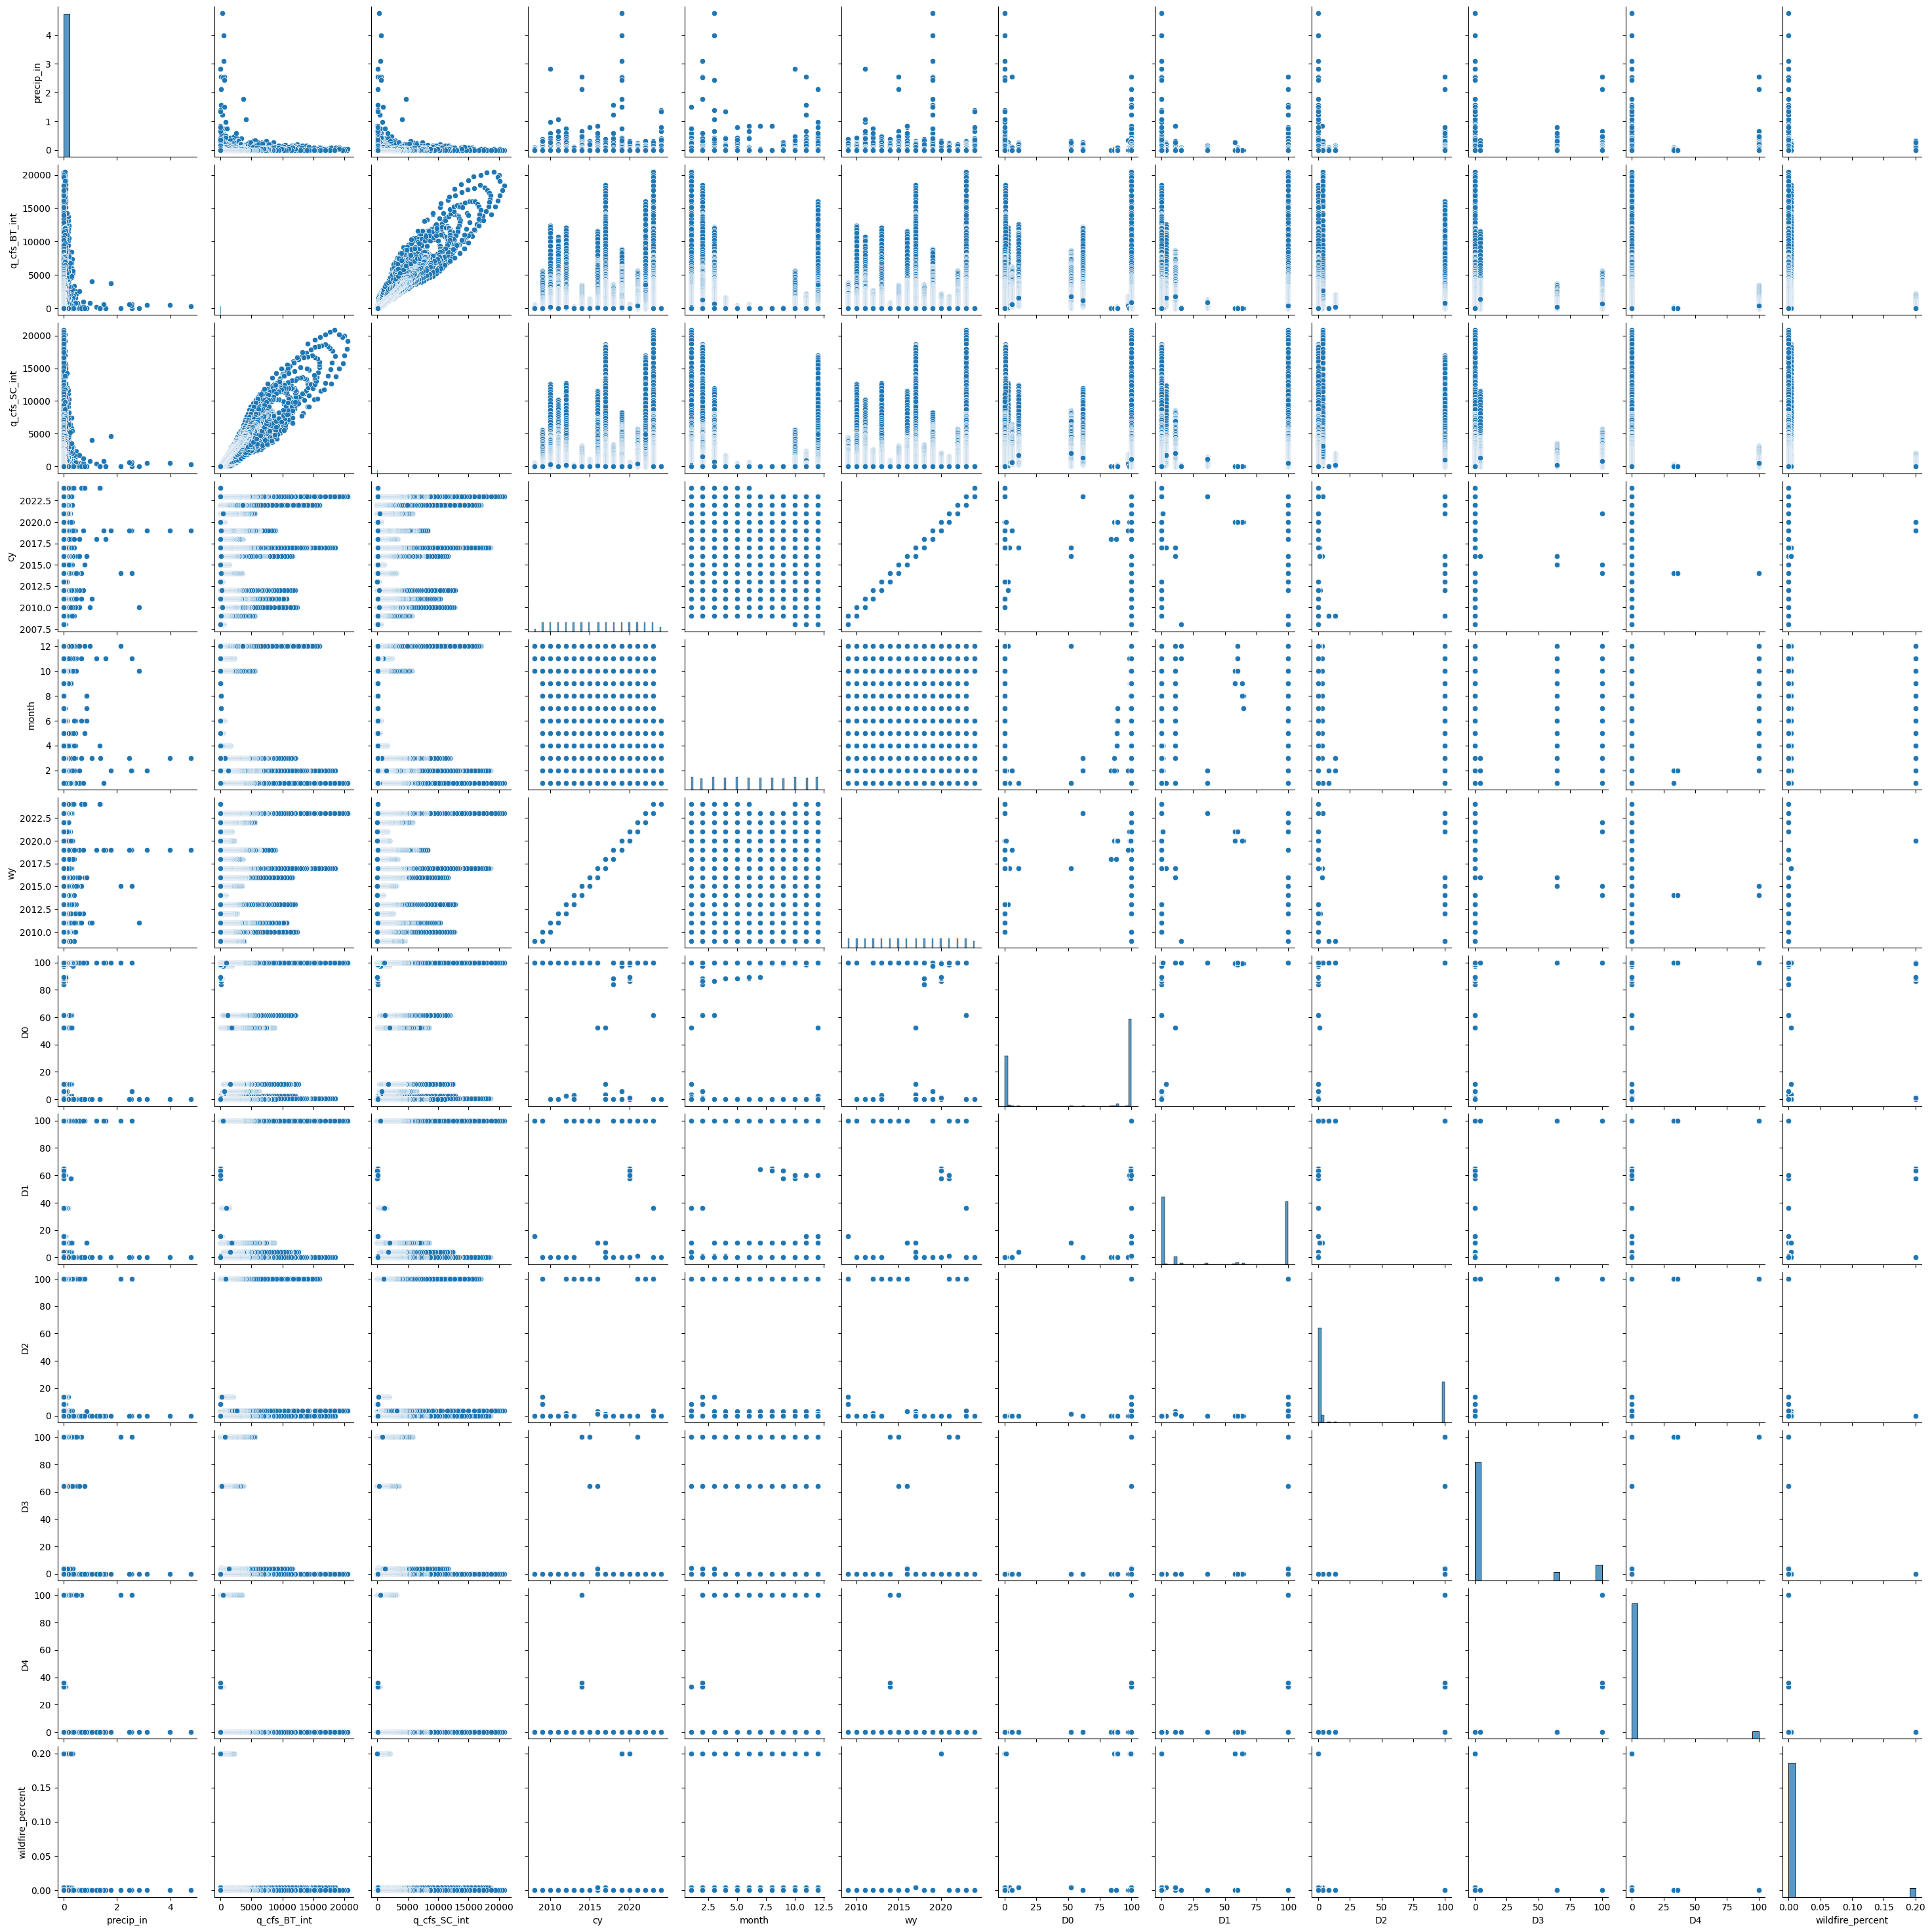

In [71]:
#plot var correlations
sns.pairplot(data)

<Axes: >

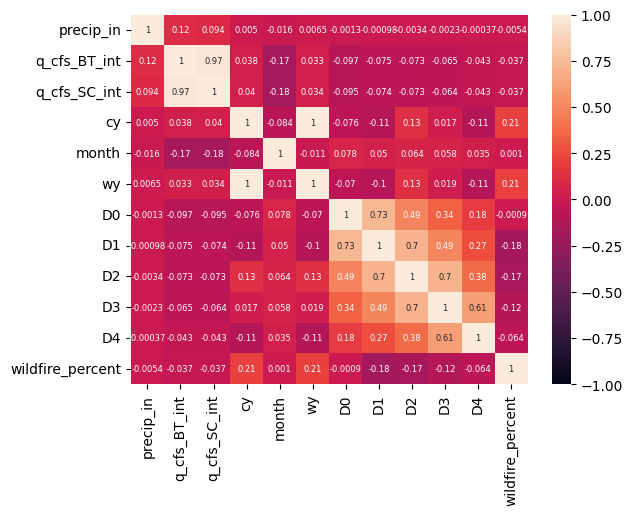

In [72]:
# plot correlation heatmap
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"size":6}) 

,lag,correlation
0,0,0.09409
96,1.0,0.068796
1440,15.0,0.079693
2784,29.0,0.076755
4128,43.0,0.078861
5472,57.0,0.077785
6816,71.0,0.080339
8160,85.0,0.088931
9504,99.0,0.08824
10848,113.0,0.087794


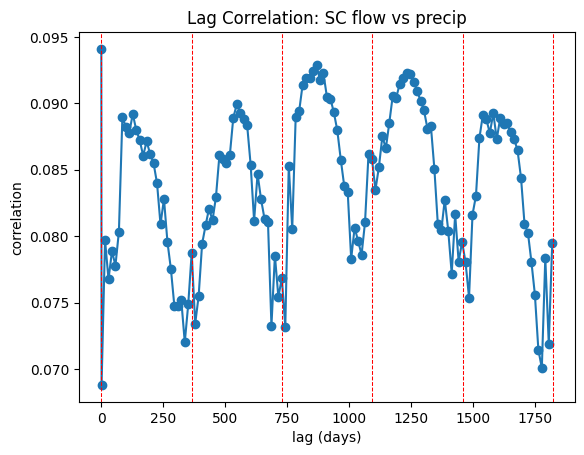

In [73]:
# calc lag correlation, plot
lag_step = np.arange(96, 96*365*5, 96*14)
lag_step
lags_out = pd.DataFrame(columns=['lag', 'correlation'])
lags_out.loc[0, :] = [0, np.corrcoef(data.q_cfs_SC_int, data.precip_in)[1,0]]
for lag in lag_step:
    data_lag = data.copy()
    data_lag.q_cfs_BT_int = data_lag.q_cfs_BT_int.diff(lag)
    data_lag.dropna(inplace=True)
    lags_out.loc[lag, :] = [lag/96, np.corrcoef(data_lag.q_cfs_BT_int, data_lag.precip_in)[1,0]]
    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out.lag, lags_out.correlation,  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.set_title('Lag Correlation: SC flow vs precip')
for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)
lags_out.head(20)

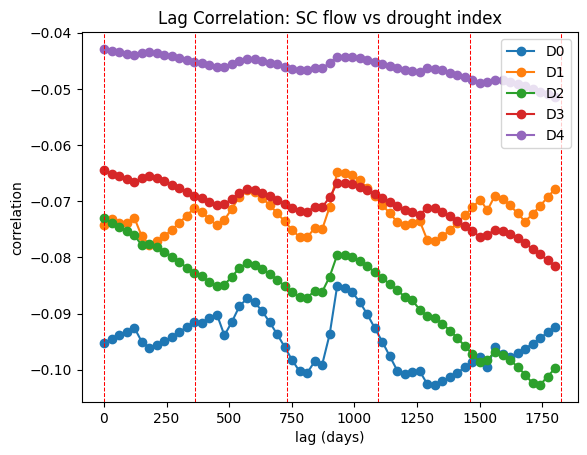

In [74]:
#lag correlation with each Drought category
lag_step = np.arange(96, 96*365*5, 96*30)
d_cat_list = ['D0', 'D1', 'D2', 'D3', 'D4']
lags_out = pd.DataFrame(columns=d_cat_list)

for d in d_cat_list:
    lags_out.loc[0, d] = np.corrcoef(data.q_cfs_SC_int, data[d])[1,0]
    
for lag in lag_step:
    data_lag = data.copy()
    data_lag.q_cfs_BT_int = data_lag.q_cfs_BT_int.diff(lag)
    data_lag.dropna(inplace=True)
    
    for d in d_cat_list:
        lags_out.loc[lag, d] = np.corrcoef(data_lag.q_cfs_SC_int, data_lag[d])[1,0]

    
f, ax = plt.subplots(1, 1)
ax.plot(lags_out.index/96, lags_out,  linestyle='-', marker='o')
ax.set_ylabel('correlation')
ax.set_xlabel('lag (days)')
ax.legend(lags_out.columns)
ax.set_title('Lag Correlation: SC flow vs drought index')

for x in np.arange(0, 6*365, 365):
    ax.axvline(x, c='r', linestyle='--', linewidth=0.75)

In [75]:
#save data
data.to_csv('01_data.csv')

## Summary
No missing data or outliers. 
Lag correlations suggest that precipitation and streamflow correlation peaks about 4 months prior, so will need to look back at least 4 months for LSTM models. 
Drought index vs streamflow shows similar results; with small bumps in correlation around 4 months prior. 

Other potential data to add if model doesn't perform well: precipitation or humidity. Soil moisture metric? Maybe watershed scale NDWI? 